In [1]:
import h5py

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import sys
sys.path.append('/gpfs01/bethge/home/sschneider/thesis/code/domainadaptation')

import analysis
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import glob
import pandas as pd

In [7]:
import re

entries = []

for fname in glob.glob('log/digits/*/*/losshistory.csv'):    
    df = pd.read_csv(fname, index_col=0)
    
    print(fname)
    
    if len(df) > 10:
        
        matches, = re.findall(r'log/digits/(.*)/.*/losshistory.csv', fname)
        source = matches
        
        datasets = ['mnist', 'usps', 'synth', 'svhn']
        datasets.pop(datasets.index(source))
        datasets = [source] + datasets
        datasets = [d.upper() for d in datasets]
        
        entries.append({
            'fname'      : fname,
            'source'     : source.upper(),
            datasets[0]  : df.ACC_0.values[-1000:].mean(),
            datasets[1]  : df.ACC_1.values[-1000:].mean(),
            datasets[2]  : df.ACC_2.values[-1000:].mean(),
            datasets[3]  : df.ACC_3.values[-1000:].mean(),
        })

stats = pd.DataFrame(entries)

stats['adapt'] = stats.source.apply(lambda x : x.upper())

stats

log/digits/mnist/20180926-125754_MultidomainBCESolver/losshistory.csv
log/digits/svhn/20180926-143322_MultidomainBCESolver/losshistory.csv
log/digits/svhn/20180926-125529_MultidomainBCESolver/losshistory.csv
log/digits/synth/20180926-125253_MultidomainBCESolver/losshistory.csv
log/digits/usps/20180926-130054_MultidomainBCESolver/losshistory.csv


,MNIST,SVHN,SYNTH,USPS,fname,source,adapt
0,0.995987,0.671581,0.920986,0.965930,log/digits/mnist/20180926-125754_MultidomainBC...,MNIST,MNIST
1,0.963737,0.957827,0.976602,0.944122,log/digits/svhn/20180926-143322_MultidomainBCE...,SVHN,SVHN
2,0.965503,0.959372,0.975233,0.948535,log/digits/svhn/20180926-125529_MultidomainBCE...,SVHN,SVHN
3,0.970778,0.860972,0.995637,0.953526,log/digits/synth/20180926-125253_MultidomainBC...,SYNTH,SYNTH
4,0.976991,0.710125,0.921894,0.999633,log/digits/usps/20180926-130054_MultidomainBCE...,USPS,USPS


Adapt + Test     MNIST      USPS     SYNTH      SVHN
Train                                               
MNIST         0.995987  0.965930  0.920986  0.671581
USPS          0.976991  0.999633  0.921894  0.710125
SYNTH         0.970778  0.953526  0.995637  0.860972
SVHN          0.964620  0.946329  0.975917  0.958599


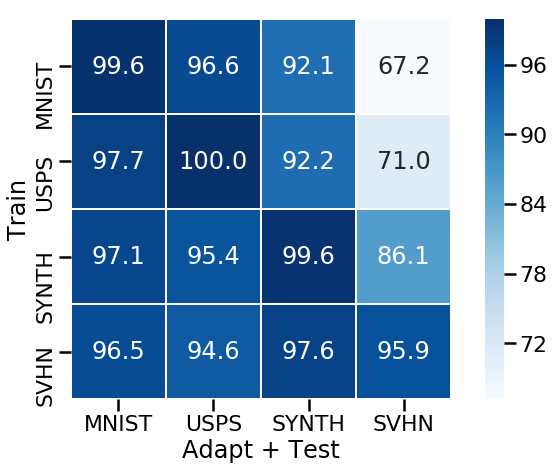

In [14]:
import seaborn as sns

mmax = stats.groupby(['adapt']).mean().reset_index()
std  = stats.groupby(['adapt']).std().reset_index()

mmax = mmax.set_index('adapt')
mmax.index.name = 'Train'
mmax.columns.name = 'Adapt + Test'

order = ['MNIST', 'USPS', 'SYNTH', 'SVHN']

mmax = mmax[order]
mmax = mmax.loc[order]

print(mmax)

sns.set_context('poster')
plt.figure(figsize=(12,7))
sns.heatmap(data=100*mmax, cmap = 'Blues', annot = True, fmt='.1f', square=True, linewidths=1)

#plt.xlabel('Benchmark')
#plt.ylabel('')
#plt.title("Max. Target Accuracy [%]")
plt.show()

In [5]:
import matplotlib.pyplot as plt

def plot_analysis(ACC, imgs, noise_vars, P):
    
    fig, ax = analysis.plot_overview(ACC, imgs, noise_vars) 
    ax.set_title(titles[which])
    yield fig

    names = ['Mean', 'Variance', u'$\gamma$', u'$\\beta$', 'Scale', 'Shift']

    sns.set_context('poster', font_scale=.9)
    for m, name in zip(P, names):
        m = m.squeeze()

        fig, (ax_angle, ax_acc, ax_tril) = plt.subplots(1,3,figsize=(15,5))
        a = analysis.compute_angle(m)
        analysis.transfer_plot(a,ACC,ax_angle, ax_acc, noise_vars)

        ax_angle.text(s=name, x=-3,y = -.75, color='gray')
        ax_angle.text(s=u'$\sigma_{train} > \sigma_{test}$',x=-.2,y=6.5,color='white')
        ax_angle.text(s=u'$\sigma_{test} > \sigma_{train}$',x=3,y=1.25,color='white')

        #ax_tril, ax_triu = plt.subplots(1,2,figsize=(10,3))[1] #,sharex=True,sharey=True)[1]
        x,y = analysis.get_corr(ACC.T, a, np.triu)
        analysis.plot_reg(x, y, ax=ax_tril)
        ax_tril.set_title('Correlation ($\sigma_{test} > \sigma_{train}$)')
        #x,y = get_corr(ACC, a, np.triu)
        #plot_reg(x, y, ax=ax_triu)
        #plt.suptitle(name)
        #plt.show()

        xticks = ax_tril.get_xticks()
        yticks = ax_tril.get_yticks()
        ax_tril.spines['bottom'].set_bounds(xticks[1],xticks[-2])
        ax_tril.spines['left'].set_bounds(yticks[1],yticks[-2])

        plt.tight_layout()
        yield fig

0 4


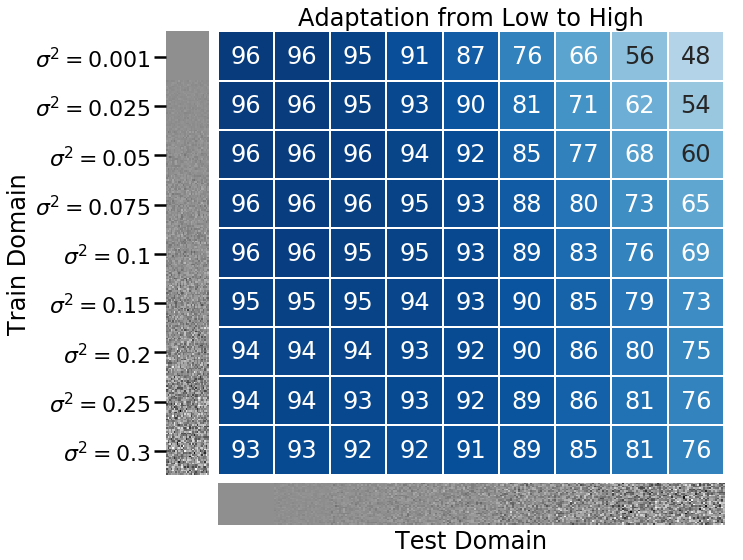

In [9]:
import os
import re
import glob

fnames = [
    'log/multi_noise_bn/clean/20180820-200625_MultidomainBCESolver/20180820-200625-checkpoint-ep90.pth',
    'log/multi_noise_bn/noise/20180820-200427_MultidomainBCESolver/20180820-200427-checkpoint-ep90.pth',
    'log/multi_noise_shot_bn/clean/20180905-165820_MultidomainBCESolver/20180905-165820-checkpoint-ep90.pth',
    'log/multi_noise_shot_bn/noise/20180905-170020_MultidomainBCESolver/20180905-170020-checkpoint-ep90.pth'
]

noisemodels = [
    datasets.clean2noise(),
    datasets.clean2noise(),
    datasets_shotnoise.clean2noise(),
    datasets_shotnoise.clean2noise()
]

regex = re.compile(r'.*/(noise)?(clean)?/.*/(.*)\.pth')

titles = {
    'noise' : 'Adaptation from High to Low',
    'clean' : 'Adaptation from Low to High'
}

from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('analysis-report.pdf') as pdf:

    for fname, noisemodel in zip(fnames, noisemodels):

        (noise, clean, name), = regex.findall(fname)
        which = noise + clean

        n_domains  = len(noisemodel)
        valfile,   = glob.glob('eval/*/{}-{}.hdf5'.format(name, which))
        ACC        = analysis.load_file(valfile, n_domains=n_domains, revert=(which == 'noise'))
        imgs       = np.stack(N(.5 + torch.zeros(28,28)).numpy() for N in noisemodel)
        noise_vars = [g.__dict__.get('sigma', 0) + g.__dict__.get('prob', 0) for g in noisemodel]
        
        fnames = list(glob.glob(fname))
        P      = analysis.load_params(fnames)
        M, B   = analysis.compute_linear(P)
        P      = list(P) + [M, B]
        
        for fig in plot_analysis(ACC, imgs, noise_vars, P):
            pdf.savefig(fig, bbox_inches='tight')
            plt.show()
            
            break
        
        break

0 4


NameError: name 'titles' is not defined

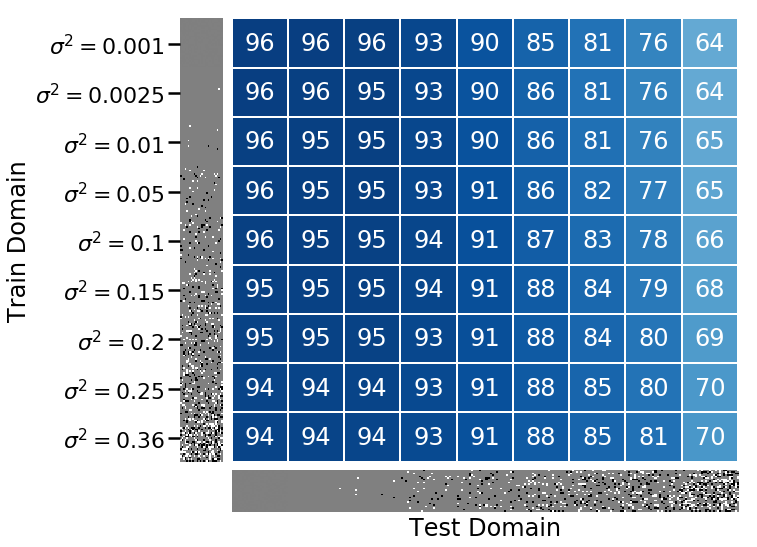

In [9]:
import glob

fname   = 'log/multi_noise_bn/noise/20180820-200427_MultidomainBCESolver/20180820-200427-checkpoint-ep90.pth'
valfile = '20180820-200427-checkpoint-ep90-clean.hdf5'

#fname   = 'log/multi_noise_bn/clean/20180820-200625_MultidomainBCESolver/20180820-200625-checkpoint-ep90.pth'
#valfile = '20180820-200625-checkpoint-ep90-clean.hdf5'


noisemodel_train = datasets_shotnoise.clean2noise()
noisemodel_test = datasets_shotnoise.clean2noise()
n_domains  = len(noisemodel_train)

ACC        = analysis.load_file(valfile, n_domains=n_domains, revert=False)
ACC = ACC[:,::-1]
imgs       = np.stack(N(.5 + torch.zeros(28,28)).numpy() for N in noisemodel_train)
noise_vars = [g.__dict__.get('sigma', 0) + g.__dict__.get('prob', 0) for g in noisemodel_test]

fnames = list(glob.glob(fname))
P      = analysis.load_params(fnames)
M, B   = analysis.compute_linear(P)
P      = list(P) + [M, B]

for fig in plot_analysis(ACC, imgs, noise_vars, P):
    plt.show()